# Real-Time Air Quality Index Analysis

**Dataset:** Indian air quality monitoring stations

**Goal:** Analyze air quality, identify pollution hotspots, compute AQI, and visualize trends

**Steps:**
1. Load and Clean Data
2. Exploratory Data Analysis (EDA)
3. Feature Engineering
4. Modeling
5. Evaluation
6. Visualization and Reporting
7. Save and Version Control

**Libraries:** pandas, numpy, matplotlib, seaborn, scikit-learn, folium

In [16]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
import folium
import pickle
import os


## 1. Load and Clean Data

- Load the CSV file into a pandas DataFrame
- Convert 'NA' to NaN
- Remove duplicates
- Impute missing pollutant_avg (mean of min/max if available)
- Ensure latitude/longitude and pollutant values are numeric

In [17]:
# Load the air quality dataset
file_path = '3b01bcb8-0b14-4abf-b6f2-c1bfd384ba69.csv'
df = pd.read_csv(file_path, na_values=['NA'])

# Remove duplicates
df = df.drop_duplicates()

# Ensure correct dtypes
for col in ['latitude', 'longitude', 'pollutant_min', 'pollutant_max', 'pollutant_avg']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Group-based imputation: fill missing pollutant_avg with mean for same station and pollutant_id
group_means = df.groupby(['station', 'pollutant_id'])['pollutant_avg'].transform('mean')
df['pollutant_avg'] = df['pollutant_avg'].fillna(group_means)

# Fallback: if still missing, impute with mean of min/max if available
mask = df['pollutant_avg'].isna() & df['pollutant_min'].notna() & df['pollutant_max'].notna()
df.loc[mask, 'pollutant_avg'] = df.loc[mask, ['pollutant_min', 'pollutant_max']].mean(axis=1)

# Show info and missing values
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country        3081 non-null   object 
 1   state          3081 non-null   object 
 2   city           3081 non-null   object 
 3   station        3081 non-null   object 
 4   last_update    3081 non-null   object 
 5   latitude       3081 non-null   float64
 6   longitude      3081 non-null   float64
 7   pollutant_id   3081 non-null   object 
 8   pollutant_min  2841 non-null   float64
 9   pollutant_max  2841 non-null   float64
 10  pollutant_avg  2841 non-null   float64
dtypes: float64(5), object(6)
memory usage: 264.9+ KB


country            0
state              0
city               0
station            0
last_update        0
latitude           0
longitude          0
pollutant_id       0
pollutant_min    240
pollutant_max    240
pollutant_avg    240
dtype: int64

## 2. Exploratory Data Analysis (EDA)

- Compute summary statistics for pollutant_avg by pollutant_id
- Group by state and city to find average pollutant levels
- Visualize:
  - Top 10 cities with highest average PM2.5 (bar chart)
  - Correlation heatmap between pollutants
  - Geospatial map of stations (folium)
- Identify outliers in pollutant values

In [ ]:
# Summary statistics for pollutant_avg by pollutant_id
summary_stats = df.groupby('pollutant_id')['pollutant_avg'].agg(['mean', 'median', 'std', 'min', 'max', 'count'])
display(summary_stats)

# Group by state and city for average pollutant levels
state_city_avg = df.groupby(['state', 'city', 'pollutant_id'])['pollutant_avg'].mean().reset_index()
display(state_city_avg.head())

,mean,median,std,min,max,count
pollutant_id,,,,,,
CO,29.983683,26.0,18.447633,2.0,106.0,429
NH3,4.378747,4.0,3.713200,1.0,43.0,367
NO2,19.318735,15.0,17.005540,1.0,155.0,411
OZONE,22.817552,20.0,14.729709,1.0,83.0,433
PM10,44.777506,43.0,19.640566,4.0,137.0,409
PM2.5,32.962963,30.0,19.093079,1.0,125.0,405
SO2,13.338501,9.0,12.539333,1.0,102.0,387


,state,city,pollutant_id,pollutant_avg
0,Andaman and Nicobar,Sri Vijaya Puram,CO,29.0
1,Andaman and Nicobar,Sri Vijaya Puram,NH3,NaN
2,Andaman and Nicobar,Sri Vijaya Puram,NO2,NaN
3,Andaman and Nicobar,Sri Vijaya Puram,OZONE,4.0
4,Andaman and Nicobar,Sri Vijaya Puram,PM2.5,NaN


### Additional Data Analytics Visualizations

- Distribution of pollutant_avg for each pollutant
- Boxplot of pollutant_avg by state
- Time series of pollutant_avg for selected stations
- Pie chart of station counts by state
- Pairplot of pollutant_avg, latitude, longitude

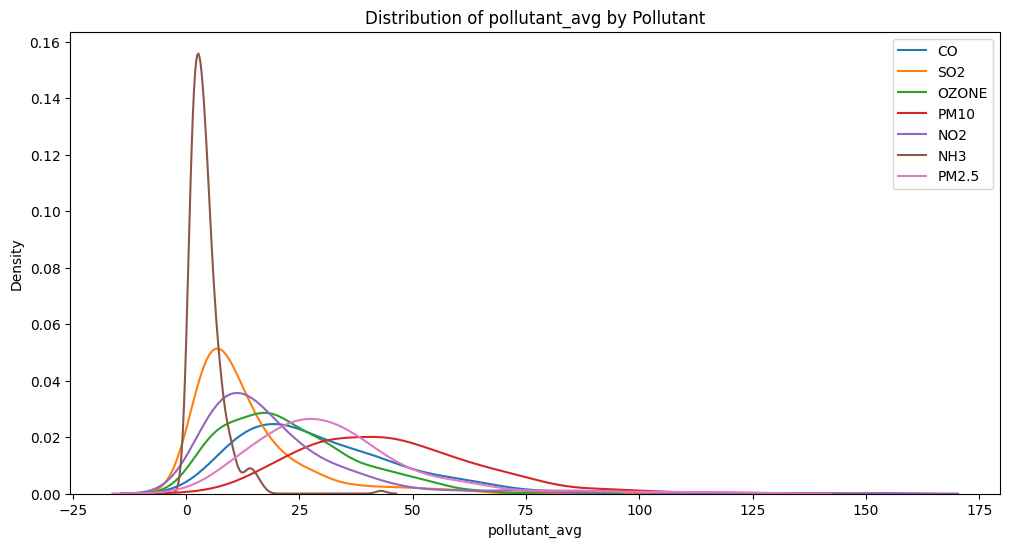

In [18]:
# Distribution of pollutant_avg for each pollutant
plt.figure(figsize=(12,6))
for pollutant in df['pollutant_id'].unique():
    sns.kdeplot(df[df['pollutant_id'] == pollutant]['pollutant_avg'].dropna(), label=pollutant)
plt.xlabel('pollutant_avg')
plt.ylabel('Density')
plt.title('Distribution of pollutant_avg by Pollutant')
plt.legend()
plt.show()

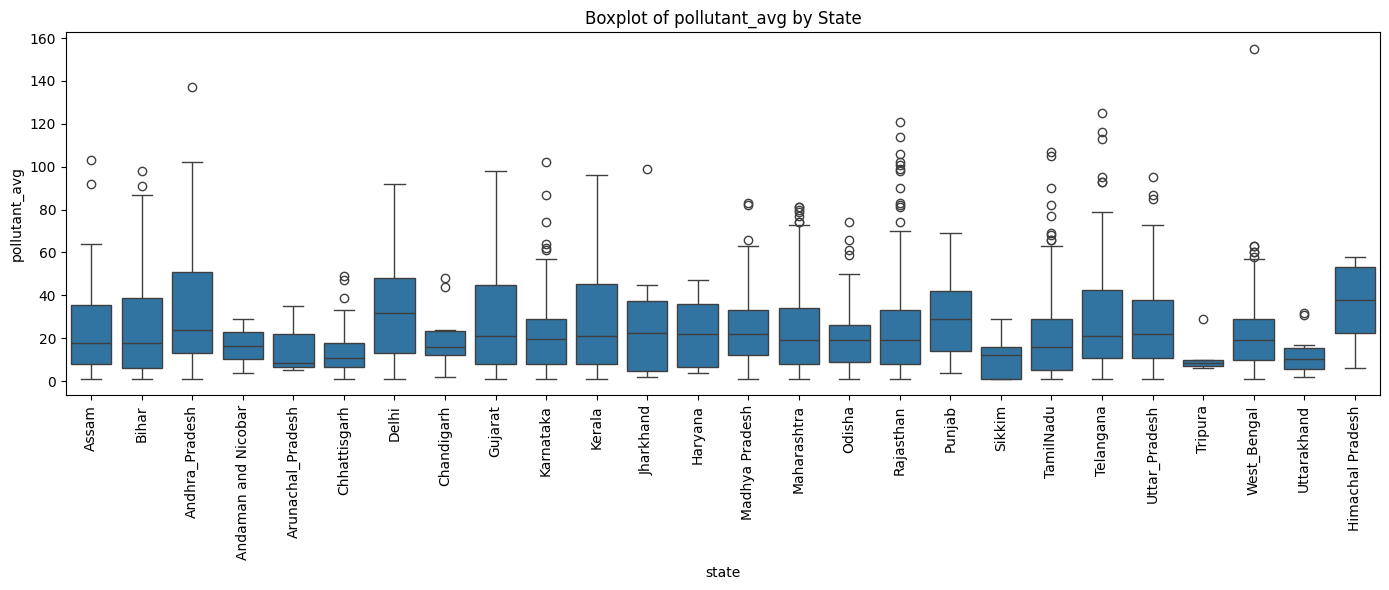

In [19]:
# Boxplot of pollutant_avg by state
plt.figure(figsize=(14,6))
sns.boxplot(x='state', y='pollutant_avg', data=df)
plt.xticks(rotation=90)
plt.title('Boxplot of pollutant_avg by State')
plt.tight_layout()
plt.show()

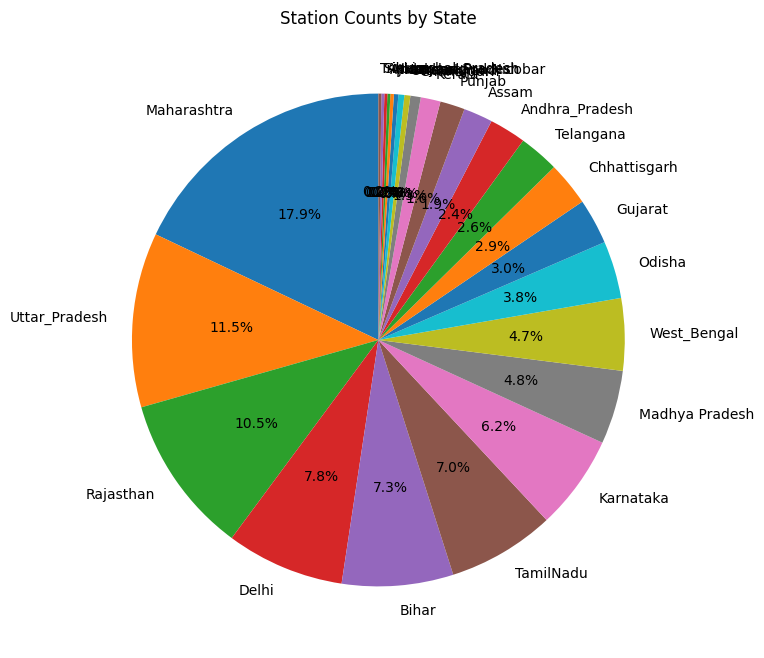

In [20]:
# Pie chart of station counts by state
station_counts = df['state'].value_counts()
plt.figure(figsize=(8,8))
station_counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Station Counts by State')
plt.ylabel('')
plt.show()

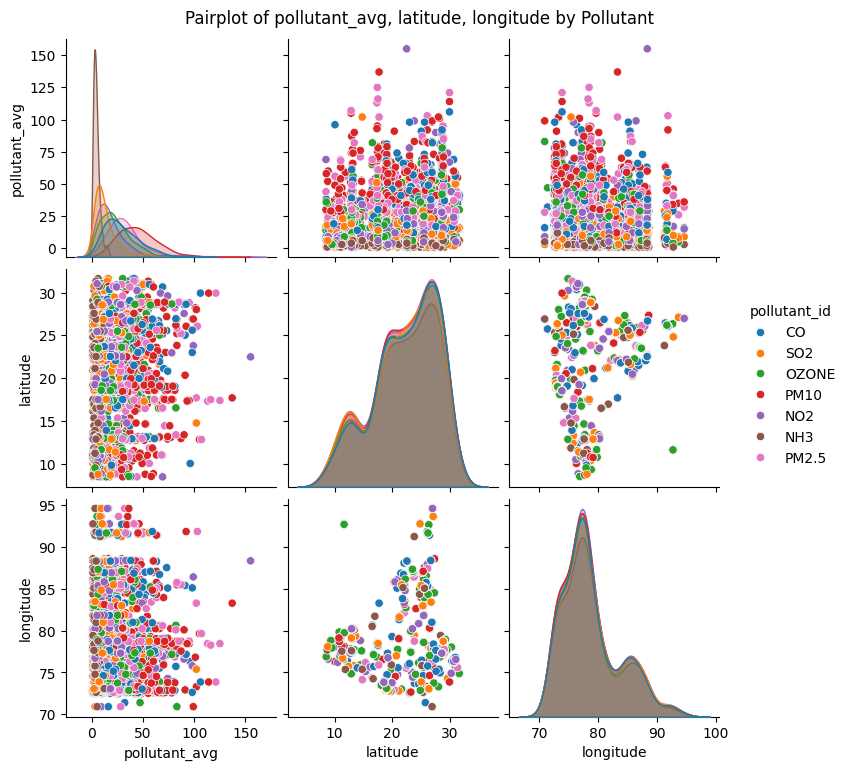

In [21]:
# Pairplot of pollutant_avg, latitude, longitude
sns.pairplot(df, vars=['pollutant_avg', 'latitude', 'longitude'], hue='pollutant_id')
plt.suptitle('Pairplot of pollutant_avg, latitude, longitude by Pollutant', y=1.02)
plt.show()

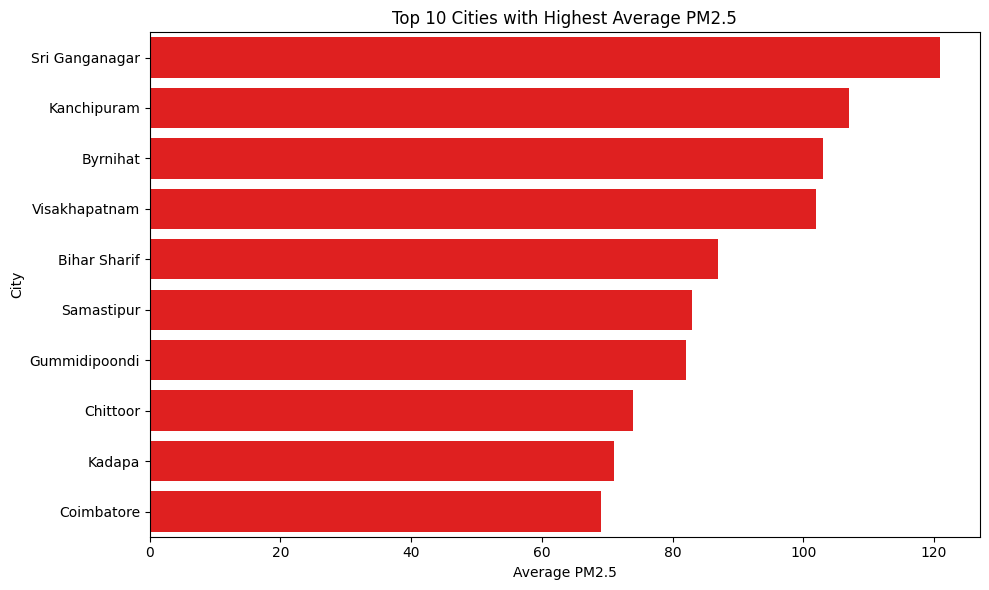

In [25]:
# Bar chart: Top 10 cities with highest average PM2.5
pm25 = df[df['pollutant_id'] == 'PM2.5']
top10_pm25 = pm25.groupby('city')['pollutant_avg'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top10_pm25.values, y=top10_pm25.index, color='red')
plt.xlabel('Average PM2.5')
plt.ylabel('City')
plt.title('Top 10 Cities with Highest Average PM2.5')
plt.tight_layout()
plt.show()

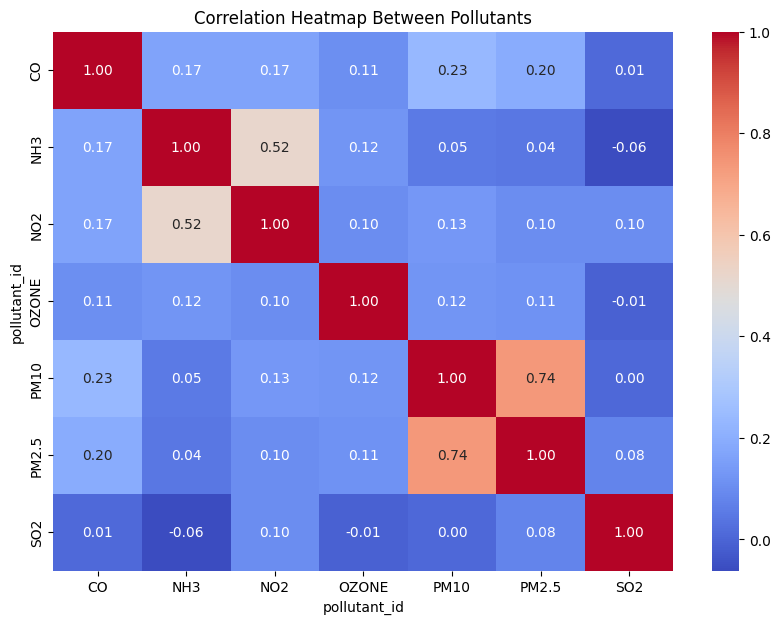

In [24]:
# Heatmap: Correlation between pollutants
pivot = df.pivot_table(index=['station'], columns='pollutant_id', values='pollutant_avg')
plt.figure(figsize=(10,7))
sns.heatmap(pivot.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap Between Pollutants')
plt.show()

In [6]:
# Geospatial map: Plot stations with pollutant_avg using folium
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=5)
for _, row in df.dropna(subset=['latitude', 'longitude', 'pollutant_avg']).iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        popup=f"{row['station']} ({row['pollutant_id']}): {row['pollutant_avg']}",
        color='red' if row['pollutant_avg'] > df['pollutant_avg'].quantile(0.9) else 'blue',
        fill=True,
        fill_opacity=0.7
    ).add_to(m)
m.save('stations_map.html')
print('Map saved as stations_map.html')

Map saved as stations_map.html


In [7]:
# Identify outliers in PM2.5 using IQR
pm25 = df[df['pollutant_id'] == 'PM2.5']
Q1 = pm25['pollutant_avg'].quantile(0.25)
Q3 = pm25['pollutant_avg'].quantile(0.75)
IQR = Q3 - Q1
outliers = pm25[(pm25['pollutant_avg'] < Q1 - 1.5 * IQR) | (pm25['pollutant_avg'] > Q3 + 1.5 * IQR)]
print(f'Number of PM2.5 outliers: {len(outliers)}')
display(outliers[['city', 'station', 'pollutant_avg']].sort_values(by='pollutant_avg', ascending=False).head(10))

Number of PM2.5 outliers: 19


,city,station,pollutant_avg
1158,Hyderabad,"Somajiguda, Hyderabad - TSPCB",125.0
1733,Sri Ganganagar,"Old City, Sri Ganganagar - RSPCB",121.0
2382,Hyderabad,"ICRISAT Patancheru, Hyderabad - TSPCB",116.0
2356,Hyderabad,"Zoo Park, Hyderabad - TSPCB",113.0
2345,Kanchipuram,"Kilambi, Kanchipuram - TNPCB",107.0
65,Byrnihat,"Central Academy for SFS, Byrnihat - PCBA",103.0
62,Visakhapatnam,"GVM Corporation, Visakhapatnam - APPCB",102.0
2478,Moradabad,"Transport Nagar, Moradabad - UPPCB",95.0
130,Delhi,"Jahangirpuri, Delhi - DPCC",91.0
1956,Delhi,"Anand Vihar, Delhi - DPCC",89.0


## 3. Feature Engineering

- Calculate AQI for each station using standard sub-index formulas
- Create new features: pollutant_range (max - min), urban_rural (based on city/station name patterns)
- One-hot encode state/city for modeling
- Normalize pollutant_avg using MinMaxScaler

In [10]:
# Calculate AQI sub-index (simplified: use pollutant_avg as sub-index, AQI = max of available sub-indices per station)
def compute_aqi_subindex(row):
    # Placeholder: in real use, use official breakpoints for each pollutant
    return row['pollutant_avg']

df['aqi_subindex'] = df.apply(compute_aqi_subindex, axis=1)

# Calculate AQI per station (max sub-index for each station)
station_aqi = df.groupby('station')['aqi_subindex'].max().reset_index().rename(columns={'aqi_subindex': 'AQI'})
df = df.merge(station_aqi, on='station', how='left')

# Create pollutant_range feature
df['pollutant_range'] = df['pollutant_max'] - df['pollutant_min']

# Create urban_rural feature (simple heuristic: if city contains 'Rural' or 'Village', else 'Urban')
def urban_rural(city):
    if pd.isna(city):
        return 'Unknown'
    if any(x in city.lower() for x in ['rural', 'village']):
        return 'Rural'
    return 'Urban'
df['urban_rural'] = df['city'].apply(urban_rural)

# One-hot encode state and city
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(df[['state', 'city']].fillna('Unknown'))
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['state', 'city']))
df = pd.concat([df.reset_index(drop=True), encoded_df], axis=1)

# Normalize pollutant_avg
scaler = MinMaxScaler()
df['pollutant_avg_norm'] = scaler.fit_transform(df[['pollutant_avg']])
df.head()

,country,state,city,station,last_update,latitude,longitude,pollutant_id,pollutant_min,pollutant_max,...,city_Varanasi,city_Vellore,city_Vijayapura,city_Vijayawada,city_Virar,city_Virudhunagar,city_Visakhapatnam,city_Vrindavan,city_Yadgir,pollutant_avg_norm
0,India,Assam,Nagaon,"Christianpatty, Nagaon - PCBA",04-09-2025 21:00:00,26.349082,92.684490,CO,3.0,46.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.201299
1,India,Assam,Nalbari,"Bata Chowk, Nalbari - PCBA",04-09-2025 21:00:00,26.446912,91.439057,SO2,4.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045455
2,India,Assam,Nalbari,"Bata Chowk, Nalbari - PCBA",04-09-2025 21:00:00,26.446912,91.439057,OZONE,1.0,54.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.077922
3,India,Assam,Silchar,"Tarapur, Silchar - PCBA",04-09-2025 21:00:00,24.828270,92.795250,PM10,43.0,53.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.292208
4,India,Assam,Silchar,"Tarapur, Silchar - PCBA",04-09-2025 21:00:00,24.828270,92.795250,NO2,15.0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.103896


## 4. Modeling

- Cluster stations using KMeans (latitude, longitude, pollutant_avg)
- Train RandomForestRegressor to predict pollutant_avg from min, max, latitude, longitude
- Split data into 80/20 train/test sets
- Use GridSearchCV for hyperparameter tuning

In [9]:
# Prepare features for clustering and regression
features = ['latitude', 'longitude', 'pollutant_avg']
model_df = df.dropna(subset=features)

# KMeans clustering to identify pollution hotspots
kmeans = KMeans(n_clusters=5, random_state=42)
model_df['cluster'] = kmeans.fit_predict(model_df[features])

# Prepare data for regression
X = model_df[['pollutant_min', 'pollutant_max', 'latitude', 'longitude']]
y = model_df['pollutant_avg']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RandomForestRegressor with GridSearchCV
param_grid = {'n_estimators': [50, 100], 'max_depth': [5, 10, None]}
rfr = RandomForestRegressor(random_state=42)
gs = GridSearchCV(rfr, param_grid, cv=3, scoring='neg_root_mean_squared_error')
gs.fit(X_train, y_train)

# Best model
best_rf = gs.best_estimator_
y_pred = best_rf.predict(X_test)

/tmp/ipykernel_10114/654118426.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['cluster'] = kmeans.fit_predict(model_df[features])


## 5. Evaluation

- Evaluate clustering with silhouette score
- Evaluate regression with RMSE and R²
- Visualize feature importance for RandomForest
- Plot predicted vs. actual pollutant_avg

Silhouette Score (KMeans): 0.343
RandomForest RMSE: 5.29
RandomForest R²: 0.93


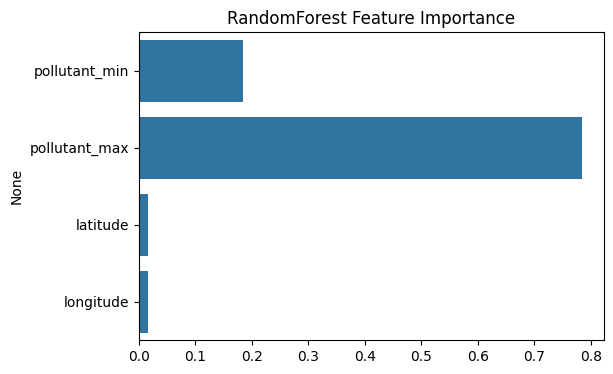

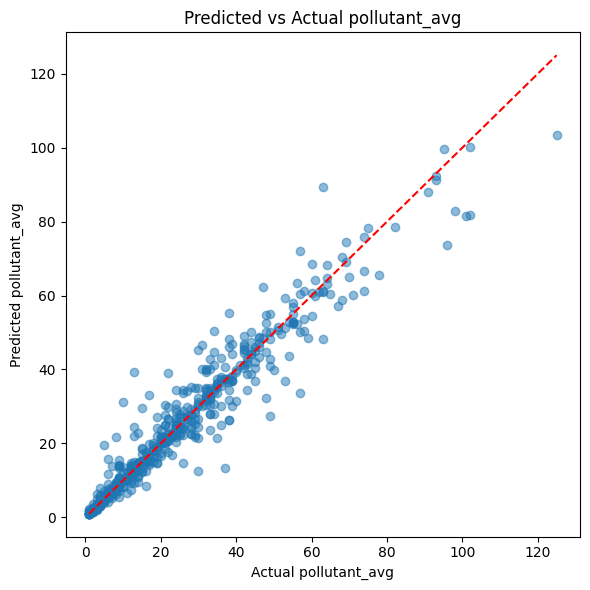

In [15]:
# Evaluate clustering
sil_score = silhouette_score(model_df[features], model_df['cluster'])
print(f'Silhouette Score (KMeans): {sil_score:.3f}')

# Evaluate regression
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Remove 'squared' argument for compatibility
r2 = r2_score(y_test, y_pred)
print(f'RandomForest RMSE: {rmse:.2f}')
print(f'RandomForest R²: {r2:.2f}')

# Feature importance
importances = best_rf.feature_importances_
plt.figure(figsize=(6,4))
sns.barplot(x=importances, y=X.columns)
plt.title('RandomForest Feature Importance')
plt.show()

# Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual pollutant_avg')
plt.ylabel('Predicted pollutant_avg')
plt.title('Predicted vs Actual pollutant_avg')
plt.tight_layout()
plt.show()

## 6. Visualization and Reporting

- Create dashboard with bar plots, heatmaps, and geospatial maps
- Save results and key findings (e.g., top polluted cities) to CSV
- Add markdown explanations for each step

In [12]:
# Save top polluted cities to CSV
top_cities = pm25.groupby('city')['pollutant_avg'].mean().sort_values(ascending=False).head(10)
top_cities.to_csv('top_polluted_cities.csv', header=['avg_pm25'])
print('Top polluted cities saved to top_polluted_cities.csv')

# Dashboard instructions
print('Dashboard: See bar chart, heatmap, and folium map outputs above. Open stations_map.html for geospatial visualization.')

Top polluted cities saved to top_polluted_cities.csv
Dashboard: See bar chart, heatmap, and folium map outputs above. Open stations_map.html for geospatial visualization.


## 7. Save and Version Control

- Save cleaned dataset and trained model as pickle files
- Write code to a Python script for reproducibility
- Add comments for clarity

In [13]:
# Save cleaned dataset and model as pickle files
df.to_pickle('cleaned_air_quality.pkl')
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(best_rf, f)
print('Cleaned dataset and model saved as pickle files.')

# Write main analysis code to a Python script for reproducibility
notebook_code = '''
# Real-Time Air Quality Index Analysis
# (See notebook for full code and explanations)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
import folium
import pickle

# ... (copy main steps from notebook here) ...
'''
with open('air_quality_analysis_script.py', 'w') as f:
    f.write(notebook_code)
print('Python script template saved as air_quality_analysis_script.py')

Cleaned dataset and model saved as pickle files.
Python script template saved as air_quality_analysis_script.py
